In [22]:
include <- function(pkg) {
  if (!suppressMessages(require(pkg, character.only = TRUE)))
    install.packages(pkg, character.only = TRUE)
  suppressMessages(library(pkg, pkg, character.only = TRUE))
}
include("ShortRead")
include("plyr")
include("magick")
include("ggplot2")
include("Biostrings")
include("proxy")
include("pheatmap")

In [23]:
# BiocManager::install("msa")
# include("msa")

In [24]:
BASE_PATH_NR1 = "/data/samples/AIRR-Seq/OURS/S3987Nr1"
BASE_PATH_NR2 = "/data/samples/AIRR-Seq/OURS/S3987Nr2"

SAMPLES = list(
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_heavy"), #1
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_light"), #2
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_heavy"), #3
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_light"), #4
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_heavy"), #5
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_light"), #6
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_heavy"), #7
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_light") #8
)

EXCLUDE_FROM_DIVERSITY_ANALYSIS = c(
    "S3987Nr1-RAMOS_heavy"
)

In [25]:
# Helpers
get_path_sample <- function(sample_name, base_path = BASE_PATH) {
    return(paste0(base_path, "/", sample_name))
}

get_path_fastq <- function(sample_name, type = "raw", base_path = BASE_PATH) {
    
    if (type == "raw") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", sample_name, ".1.fastq"
            )
        )
    } else if (type == "primer_pass") {
        suffix = ".1_primers-pass.fastq"
    } else if (type == "pair_pass"){
        suffix = ".1_primers-pass_pair-pass.fastq"
    } else if (type == "under2") {
        suffix = "_under-2.fastq"
    } else if (type == "atleast2") {
        suffix = "_atleast-2.fastq"
    } else {
        stop(paste0("Unsupported fastq file type: ", type))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "presto",
            "/", sample_name, suffix
        )
    )
}

get_path_igblast <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path), 
            "/", "changeo_igblast", 
            "/", sample_name, "_db-pass_with_translation.tsv"
        )
    )
}

get_path_clones <- function(sample_name, clone_file = "groups", base_path = BASE_PATH) {
    
    if (clone_file == "groups") {
        suffix = "_novj_groups.tsv"
    } else if (clone_file == "clones") {
        suffix = "_novj_with_clones.tsv"
    } else if (clone_file == "counts") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", "clones", 
                "/", "diversity_novj",
                "/", sample_name, "_clone_counts.tsv"
            )
        )
    } else {
        stop(paste0("Unknown clone_file type: ", clone_file))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", sample_name, suffix
        )
    )
}

get_path_coverages <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity_novj",
            "/", sample_name, "_coverages.tsv"
        )
    )
}

get_path_diversity <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity_novj",
            "/", sample_name, "_diversity.tsv"
        )
    )
}

get_path_pngs <- function(sample_name, img_type = "abundancy", base_path = BASE_PATH) {
    
    if (img_type == "abundancy") {
        suffix = "_abundancy_curve.png"
    } else if (img_type == "diversity") {
        suffix = "_diversity.png"
    } else if (img_type == "clones") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", "clones",
                "/", sample_name, "_with_clones.png"
            )
        )
    } else {
        stop("Image type = ", img_type, " is not supported.")
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity",
            "/", sample_name, suffix
        )
    )
}

read_tsv <- function(filepath) {
    return(read.csv(filepath, sep='\t'))
}

### Characterize sequencing results for each sample

In [26]:
# fp = get_path_fastq(SAMPLES[[1]]$name, type = "atleast2", SAMPLES[[1]]$base_path)
# print(fp)
# qa_summary = ShortRead::qa(fp, type = "fastq")

In [27]:
# report_html(qa_summary, "test.html")

In [7]:
count_reads_fastq <- function(fastq_path) {
    return(
        ShortRead::countFastq(fastq_path)$records
    )
}

In [8]:
res <- sapply(
    SAMPLES,
    function(sample) {
        counts = cbind(
            sample$name,
            count_reads_fastq(get_path_fastq(sample$name, type = "raw", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "primer_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "pair_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "under2", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "atleast2", sample$base_path))
        )
        return(counts)
    }
)

res <- data.frame(t(res))
colnames(res) = c("sample_name", "raw", "primer_pass", "pair_pass", "under2", "atleast2")

res$seq_batch = sapply( strsplit(res$sample_name, "-"), function(x) {x[1]} )
res$sample_type = sapply( strsplit(res$sample_name, "-"), function(x) {x[2]} )

for (col_idx in 2:6) {
    res[, col_idx] = as.integer( res[, col_idx] )
}

res

sample_name,raw,primer_pass,pair_pass,under2,atleast2,seq_batch,sample_type
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
S3987Nr1-PBMC1_heavy,293087,293087,293087,127350,14008,S3987Nr1,PBMC1_heavy
S3987Nr1-PBMC1_light,264459,264459,264459,108203,13384,S3987Nr1,PBMC1_light
S3987Nr1-RAMOS_heavy,160952,160952,160952,28,5,S3987Nr1,RAMOS_heavy
S3987Nr1-RAMOS_light,69991,69991,69991,25974,3791,S3987Nr1,RAMOS_light
S3987Nr2-PBMC1_heavy,4130140,4130140,4130140,1336389,187452,S3987Nr2,PBMC1_heavy
S3987Nr2-PBMC1_light,3756935,3756935,3756935,1099571,170346,S3987Nr2,PBMC1_light
S3987Nr2-RAMOS_heavy,2273707,2273707,2273707,511006,82177,S3987Nr2,RAMOS_heavy
S3987Nr2-RAMOS_light,1042385,1042385,1042385,270362,42482,S3987Nr2,RAMOS_light


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


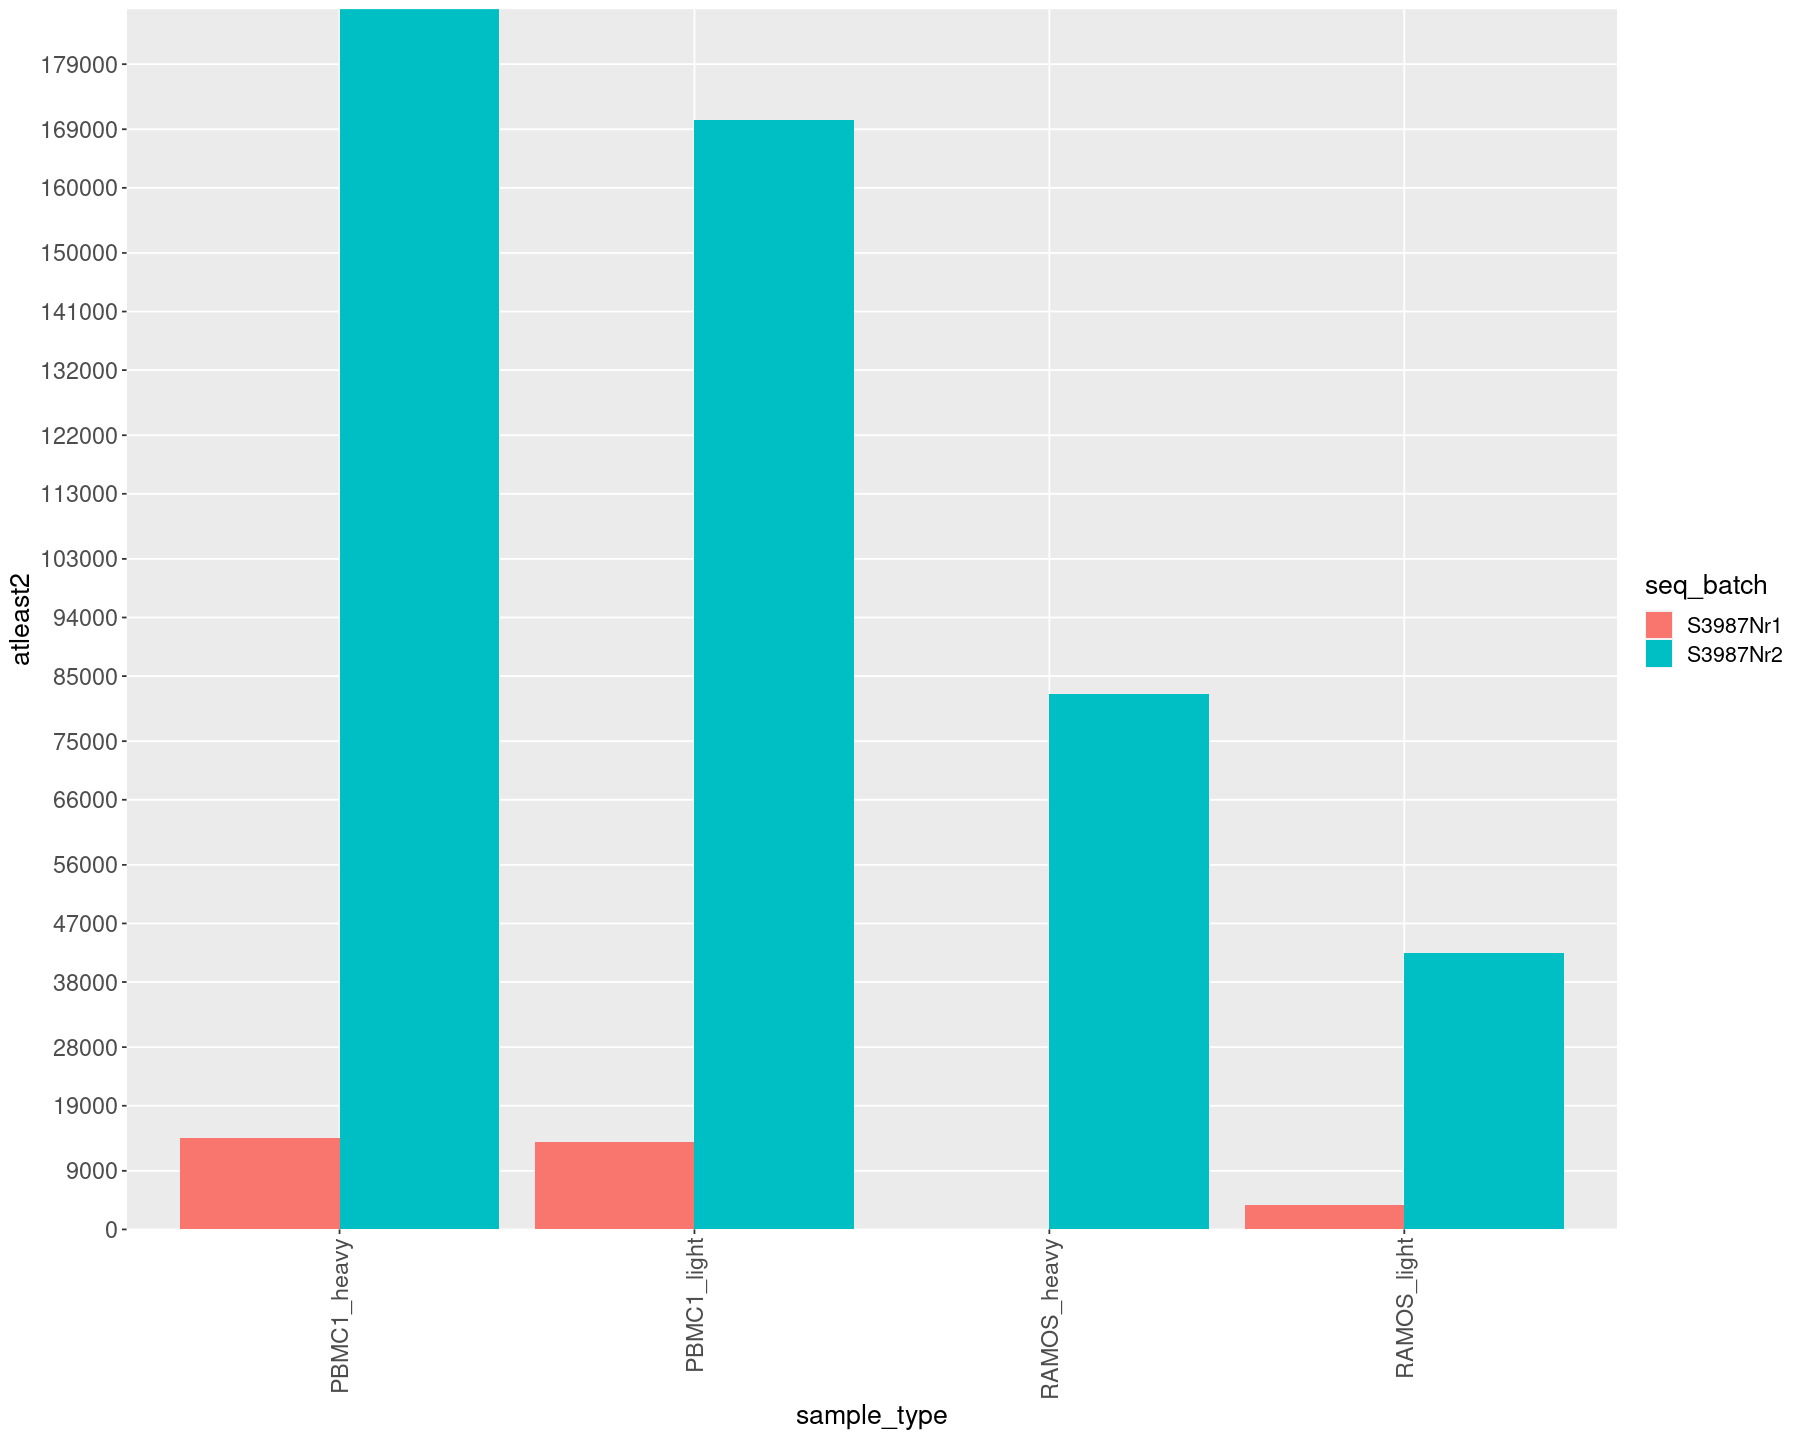

In [9]:
colname = "atleast2"

saved <- options(repr.plot.width=15, repr.plot.height=12)

num_ticks = 20
max_val = max(res[colname])
min_val = min(res[colname])

tick_spacing = plyr::round_any( (max_val - min_val) / num_ticks, 100)

g = (
    ggplot2::ggplot(data = res, aes(fill = seq_batch, x = sample_type, y = get(colname))) 
    + ggplot2::geom_bar(stat = "identity", position = "dodge")  # dodge, stack
    + ggplot2::scale_y_discrete(
        limit = plyr::round_any(seq(min_val, max_val, tick_spacing), 1000)
    )
    + ggplot2::ylab(colname)
    + ggplot2::theme(text = element_text(size = 16),
            axis.text = element_text(size=14), 
            axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    )
print(g)

options(saved)

### Compare clone counts

In [10]:
columnar_dataframe_builder <- function(values_vec, colnames) {
    df = data.table::transpose(data.frame(values_vec))
    colnames(df) = colnames
    return(df)
}

aggregate_tsvs <- function(samples, path_builder, mode = "headers", nrows = 5, processor = NULL) {
    
    if (!(mode %in% c("headers", "processor"))) {
        stop(paste0("Mode not supported: ", mode))
    }
    
    df_res = data.frame()
    for (i in 1:length(samples)) {
        
        sample = samples[[i]]
        filepath = path_builder(sample$name, sample$base_path)
        
        if (file.exists(filepath)) {
            
            if (mode == "headers") {
                tsv_head = head(read_tsv(filepath), n = nrows)
                tsv_nrow = nrow(tsv_head)
                if (tsv_nrow > 0) {
                    df_annotated = cbind(sample$name, 1:tsv_nrow, tsv_head)
                    df_res = plyr::rbind.fill(df_res, df_annotated)
                } else {
                    print(paste0("0 rows for: ", filepath))
                }
            } else if (mode == "processor") {
                tsv = read_tsv(filepath)
                df_processed = processor(tsv)
                df_annotated = cbind(sample$name, df_processed)
                df_res = plyr::rbind.fill(df_res, df_annotated)
            }
        
        } else {
            print(paste0("Filepath not found: ", filepath))
        }
    }
    ncol = ncol(df_res)
    colnames(df_res) <- c("sample_name", "rank", colnames(df_res)[3:ncol])
    return(df_res)
}

In [11]:
clone_counts = aggregate_tsvs(
    SAMPLES,
    function(name, base_path) {get_path_clones(name, "counts", base_path)},
    nrows = 10
)
clone_counts

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_clone_counts.tsv"


sample_name,rank,clone_id,seq_count,copy_count,seq_freq,copy_freq
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
S3987Nr1-PBMC1_heavy,1,537,1628,24866,0.1248370524,0.1944251144
S3987Nr1-PBMC1_heavy,2,357,717,10746,0.0549804463,0.0840220493
S3987Nr1-PBMC1_heavy,3,865,780,8911,0.0598113642,0.0696743422
S3987Nr1-PBMC1_heavy,4,438,533,8079,0.0408710988,0.0631690058
S3987Nr1-PBMC1_heavy,5,1253,536,7377,0.0411011426,0.0576801282
S3987Nr1-PBMC1_heavy,6,1157,330,3096,0.0253048079,0.0242073576
S3987Nr1-PBMC1_heavy,7,1201,220,1913,0.0168698719,0.0149575824
S3987Nr1-PBMC1_heavy,8,896,206,1856,0.0157963346,0.0145119043
S3987Nr1-PBMC1_heavy,9,1091,193,1754,0.0147994786,0.0137143751


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


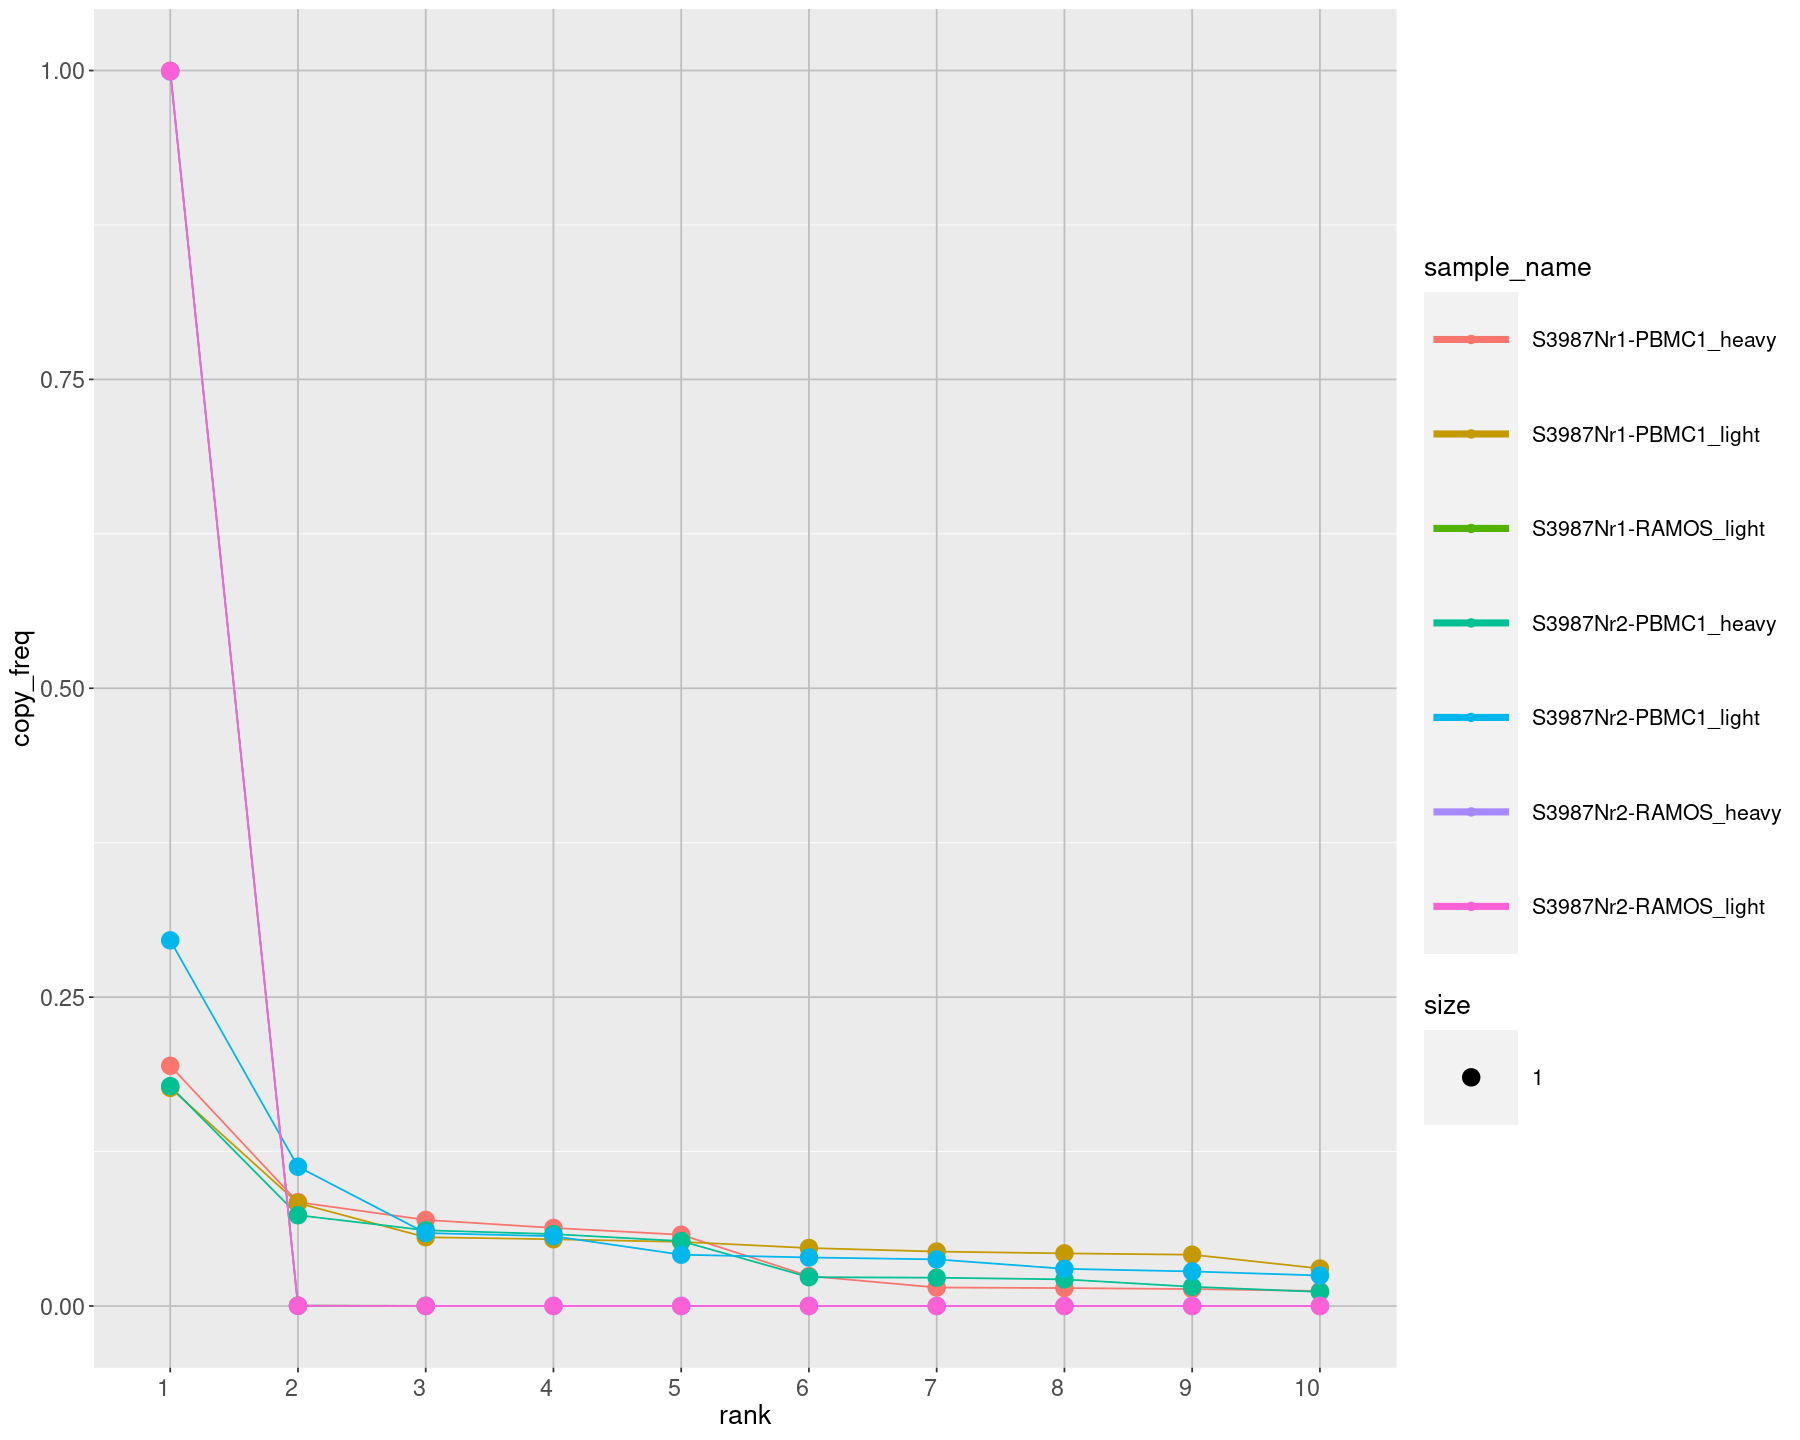

In [12]:
colname = "copy_freq"  # seq_count, copy_count, seq_freq, copy_freq

saved <- options(repr.plot.width=15, repr.plot.height=12)

g = (
    ggplot2::ggplot(data = clone_counts, aes(x = rank, y = get(colname))) 
    + ggplot2::geom_line(aes(color = sample_name))
    + ggplot2::geom_point(aes(color = sample_name, size = 1))
    + ggplot2::scale_x_discrete(limits = 1:10)
#     + scale_y_discrete(limits = seq(0, 1, 0.1))
    + ggplot2::ylab(colname)
    + ggplot2::theme(text = element_text(size = 16),
            axis.text = element_text(size=14), 
            axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1),
            legend.key.size = unit(2, "cm"),
            legend.key.width = unit(2, "cm"))
    + ggplot2::theme(panel.grid.major = element_line(colour = "gray"))
    + ggplot2::guides(color = guide_legend(override.aes = list(size = 2)))
    )
print(g)

options(saved)


### Top k clones similarity

In [29]:
sample_pair = list(SAMPLES[[1]], SAMPLES[[5]])


tsv1 = read_tsv(get_path_clones(sample_pair[[1]]$name, "clones", sample_pair[[1]]$base_path))
tsv2 = read_tsv(get_path_clones(sample_pair[[2]]$name, "clones", sample_pair[[2]]$base_path))

In [33]:
align_pairwise <- function(seq1, seq2) {
    return(
        Biostrings::pairwiseAlignment(seq1, seq2, scoreOnly=TRUE)
    )
}

sequence_identity <- function(seq1, seq2) {
    align = Biostrings::pairwiseAlignment(seq1, seq2)
    return(
        Biostrings::pid(align, "PID2")
    )
}

In [34]:
nclones = 10
feature = "sequence"
similarity_func = sequence_identity


seqs_1 = tsv1[1:nclones, feature]
seqs_2 = tsv2[1:nclones, feature]

d = proxy::dist(as.list(seqs_1), as.list(seqs_2), method = similarity_func)
colnames(d) = paste0("seqs?_", 1:nclones)
rownames(d) = paste0("seqs?_", 1:nclones)

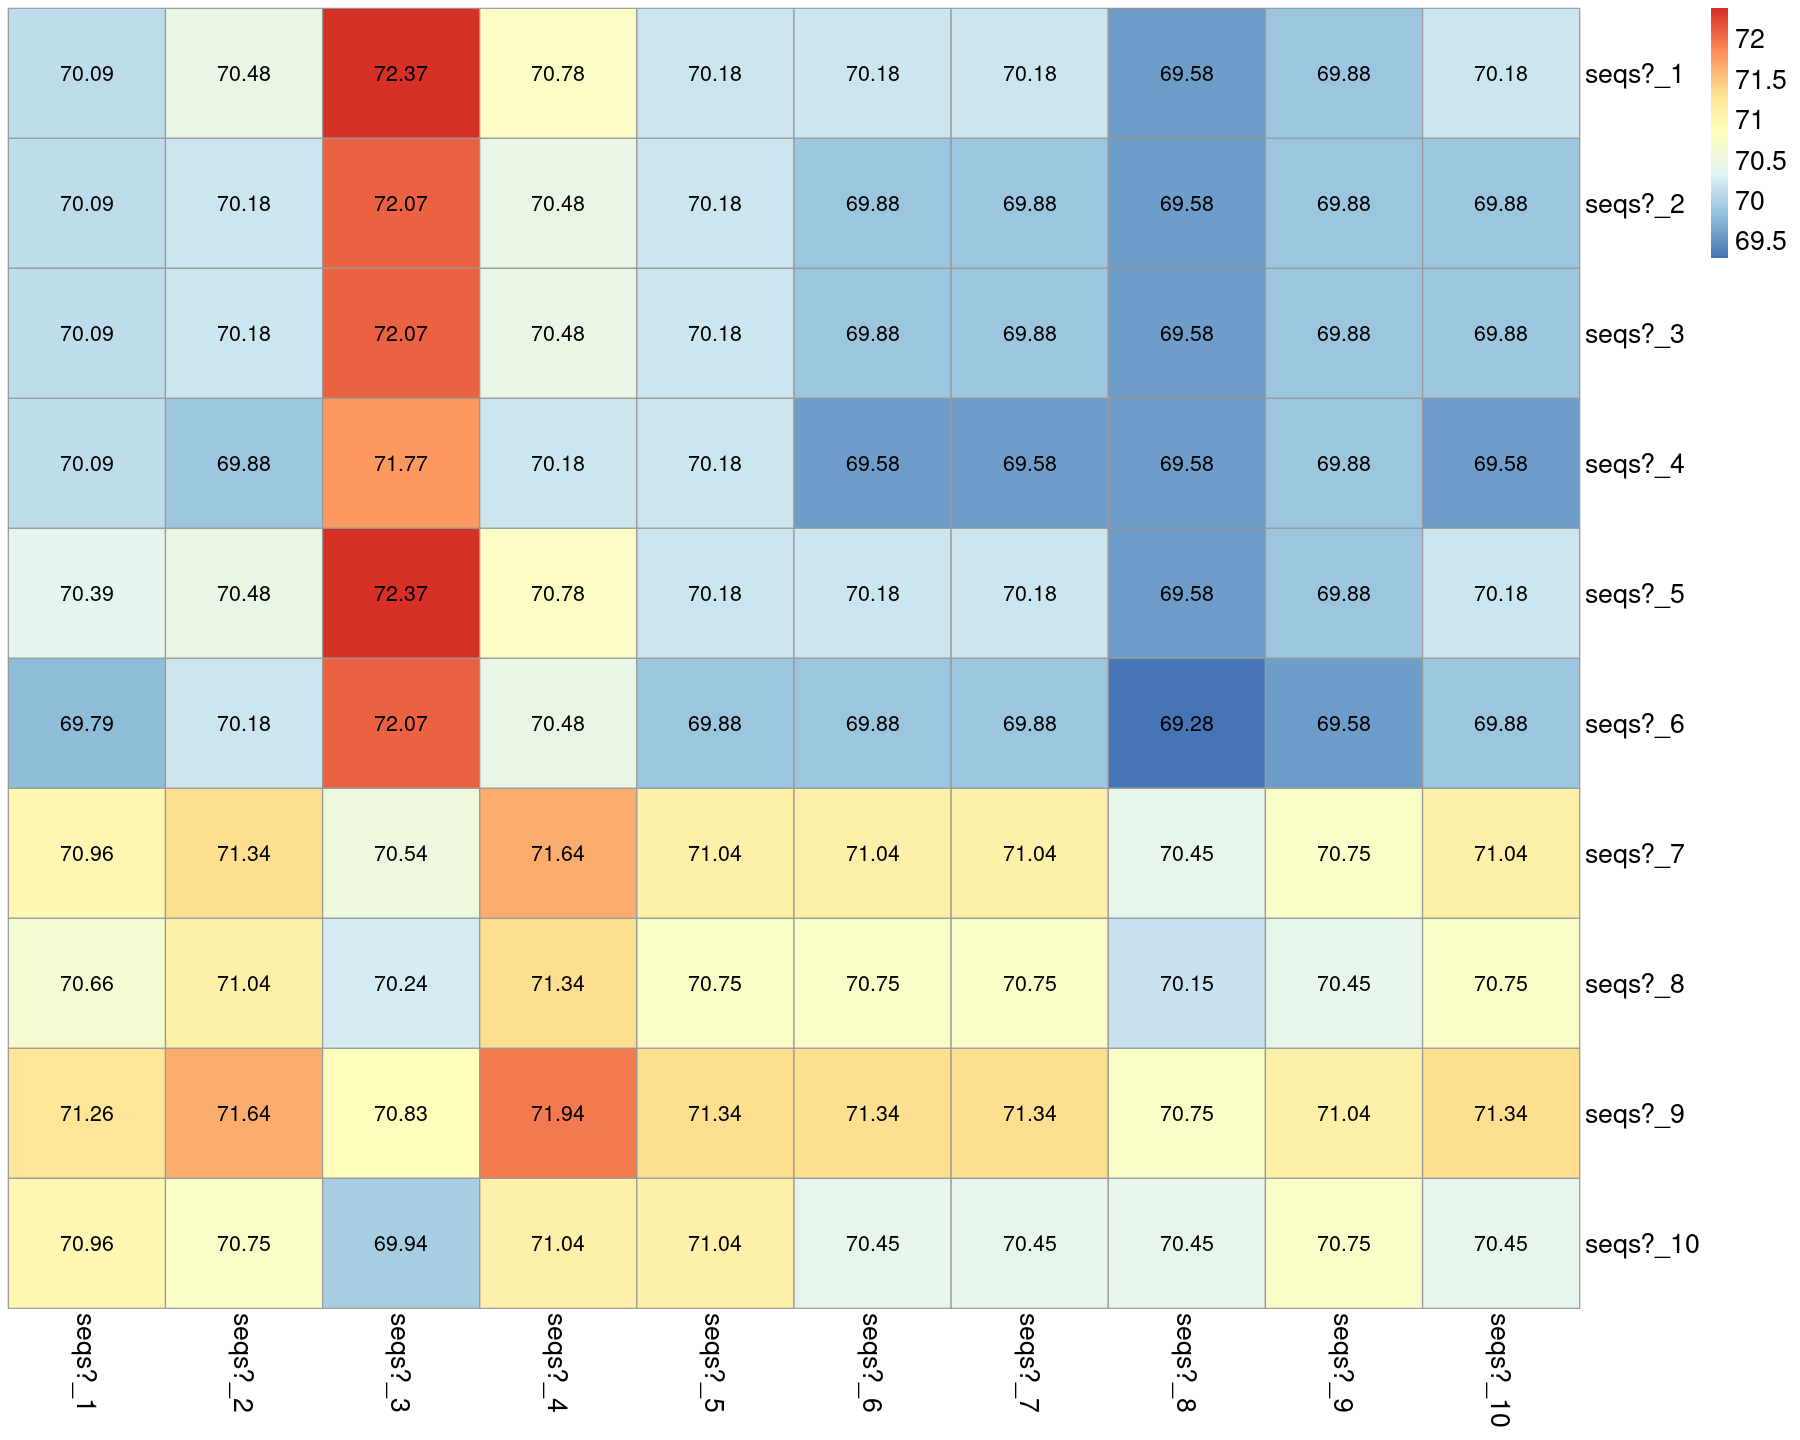

In [35]:
saved <- options(repr.plot.width=15, repr.plot.height=12)

pheatmap::pheatmap(
    d, 
    cluster_rows=FALSE, cluster_cols=FALSE, 
    show_rownames=TRUE, show_colnames=TRUE, 
    display_numbers=TRUE, number_color = "black", 
    fontsize=16)

options(saved)

### Abundancy and diversity comparisons among samples

In [17]:
coverages_df = aggregate_tsvs(
    SAMPLES, 
    function(sample_name, base_path) {get_path_coverages(sample_name, base_path)}, 
    nrows = 10
)
coverages_df

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_coverages.tsv"


sample_name,rank,X1.order,coverages
<chr>,<int>,<int>,<dbl>
S3987Nr1-PBMC1_heavy,1,1,0.9723967
S3987Nr1-PBMC1_heavy,2,2,0.9999307
S3987Nr1-PBMC1_heavy,3,3,0.9999999
S3987Nr1-PBMC1_heavy,4,4,1.0000000
S3987Nr1-PBMC1_heavy,5,5,1.0000000
S3987Nr1-PBMC1_heavy,6,6,1.0000000
S3987Nr1-PBMC1_heavy,7,7,1.0000000
S3987Nr1-PBMC1_heavy,8,8,1.0000000
S3987Nr1-PBMC1_heavy,9,9,1.0000000


In [18]:
diversity <- read_tsv(
    get_path_diversity(SAMPLES[[1]]$name, SAMPLES[[1]]$base_path)
)

interpret_diversity <- function(diversity_df) {

    extract_div_by_q <- function(q) {diversity_df[diversity$q == q, ]$d}
    
    species_richness <- extract_div_by_q(0)
    D_1 <- extract_div_by_q(1)
    D_2 <- extract_div_by_q(2)
    D_3 <- extract_div_by_q(3)
    D_4 <- extract_div_by_q(4)
    shannon_index <- log(D_1, 2)
    gini_simpson_index <- 1 - 1/D_2
    
    res = columnar_dataframe_builder(
        values_vec = c(species_richness, D_1, D_2, D_3, D_4, shannon_index, gini_simpson_index),
        colnames = c("Species_richness_D_0", "D_1", "D_2", "D_3", "D_4", "Shannon_uncertainty", "Gini_simpson_prob")
    )
    
#     res = data.frame(
#         c("Species_richness_D_0", "D_1", "D_2", "D_3", "D_4", "Shannon_uncertainty", "Gini_simpson_prob"), 
#         c(species_richness, D_1, D_2, D_3, D_4, shannon_index, gini_simpson_index)
#     )
    return(res)
}

In [19]:
# head(diversity)
# interpret_diversity(diversity)
aggregate_tsvs(
    SAMPLES,
    get_path_diversity,
    mode = "processor",
    processor = interpret_diversity
)

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_diversity.tsv"


sample_name,rank,D_1,D_2,D_3,D_4,Shannon_uncertainty,Gini_simpson_prob
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S3987Nr1-PBMC1_heavy,1188.540,209.010609,35.522614,19.949093,15.411330,7.70743236,0.971848918
S3987Nr1-PBMC1_light,514.045,66.825807,26.139641,18.112373,14.680434,6.06233346,0.961743927
S3987Nr1-RAMOS_light,2.900,1.016294,1.004235,1.003177,1.002823,0.02331768,0.004217136
S3987Nr2-PBMC1_heavy,2432.555,243.943097,53.479603,28.577138,21.071678,7.93040085,0.981301282
S3987Nr2-PBMC1_light,1132.500,44.027602,11.617841,7.543712,6.205306,5.46033638,0.913925489
S3987Nr2-RAMOS_heavy,42.740,1.025470,1.005080,1.003808,1.003384,0.03628584,0.005054330
S3987Nr2-RAMOS_light,10.335,1.014191,1.003181,1.002386,1.002120,0.02032966,0.003171123


### Join plots

In [17]:
# magick::image_append(magick::image_scale(img, "100"), stack = TRUE)

In [21]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "abundancy", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "abundancy", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "abundancy", SAMPLES[[3]]$base_path))
comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")

In [23]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "diversity", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "diversity", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "diversity", SAMPLES[[3]]$base_path))
# img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "clones", SAMPLES[[4]]$base_path))

comb_img = comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")

In [22]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "clones", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "clones", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "clones", SAMPLES[[3]]$base_path))
# img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "clones", SAMPLES[[4]]$base_path))

comb_img = comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")